In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import yaml

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from scipy import stats

import sys
import os

backend_path = os.path.abspath('../backend/src/data')
sys.path.append(backend_path)
from get_metrics import get_metrics

config_path = r'../config/params.yml'
config = yaml.load(open(config_path), Loader=yaml.FullLoader)

In [75]:
config

{'parcing': {'pred_days': 0.15,
  'URL': 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To='},
 'preprocessing': {'pred_days': 0.15, 'random_sate': 42},
 'train': {'random_sate': 42,
  'backend_path': '../backend/src/data',
  'data_path': '../data',
  'model_path': '../models/prophet.json',
  'study_path': '../models/study.json',
  'metrics_path': '..report/metrics.json',
  'params_path': '..report/best_params.json'},
 'evaluate': {'predict_path': '../data/check/test.csv'},
 'frontend': {'main_image': '../data/frontend/main_image.png'},
 'endpoints': {'parcer': 'http://fatsapi:8000/parcer',
  'train': 'http://fastapi:8000/train',
  'prediction_test': 'http://fastapi:8000/prediction_test',
  'prediction_future': 'http://fastapi:8000/prediction_future'}}

## Описание работы
Проект использует данные по ключевой ставке Банка России для прогнозирования ее значений в будущем с помощью моделей Prophet и NeuralProphet. Основные шаги проекта:
- Сбор исторических данных по ключевой ставке ЦБ РФ с официального сайта.
- Предобработка данных: очистка, заполнение пропусков, преобразование в формат для моделей.
- Разделение данных на обучающую и тестовую выборки.
- Обучение моделей Prophet и NeuralProphet на обучающей выборке. Prophet использует аддитивную модель с трендом и сезонностью, NeuralProphet - нейросетевую модель с аналогичными компонентами.
- Оценка качества моделей на тестовой выборке по метрикам RMSE, MAE, MAPE.
- Использование лучшей модели для прогнозирования ключевой ставки на заданный горизонт в будущем.
- Анализ полученных прогнозов, сравнение с фактическими данными и решениями ЦБ РФ по ставке
- Обучение моделей Prophet и NeuralProphet на полной выборке и предсказание ставки на будущие периоды<br>

Target - предсказание курса ключевой ставки ЦБ РФ
-   date - дата
-   key_rate - значение ключевой ставки ЦБ РФ

# Parcing data

In [76]:
def get_dataset(config):
    """
    Парсит ключевую ставку с URL сайта ЦБ РФ и возвращает pandas DataFrame.

    Параметры:
    config (dict): Словарь конфигурации, содержащий URL для парсинга.

    Возвращает:
    pd.DataFrame: DataFrame, содержащий спарсенные данные ключевой ставки.
    """
    url = config['parcing']["URL"] + date.today().strftime('%d.%m.%Y')
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")
    table = soup.find_all("table")

    df = pd.read_html(str(table))[0]
    df.iloc[:, 1:] /= 100
    df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)
    df.columns = ['date', 'key_rate']

    return df

In [77]:
# Парсинг ключевой ставки в df
df = get_dataset(config)

C:\Users\myxa-\AppData\Local\Temp\ipykernel_6836\651131590.py:18: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
C:\Users\myxa-\AppData\Local\Temp\ipykernel_6836\651131590.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       18.0
1       18.0
2       18.0
3       18.0
4       18.0
        ... 
2725     5.5
2726     5.5
2727     5.5
2728     5.5
2729     5.5
Name: Ставка, Length: 2730, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, 1:] /= 100


In [78]:
# Общая информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730 entries, 0 to 2729
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2730 non-null   datetime64[ns]
 1   key_rate  2730 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.8 KB


In [79]:
# Основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2730.000000
mean,8.973535
std,3.420103
min,4.250000
25%,7.000000
50%,7.750000
75%,11.000000
max,20.000000


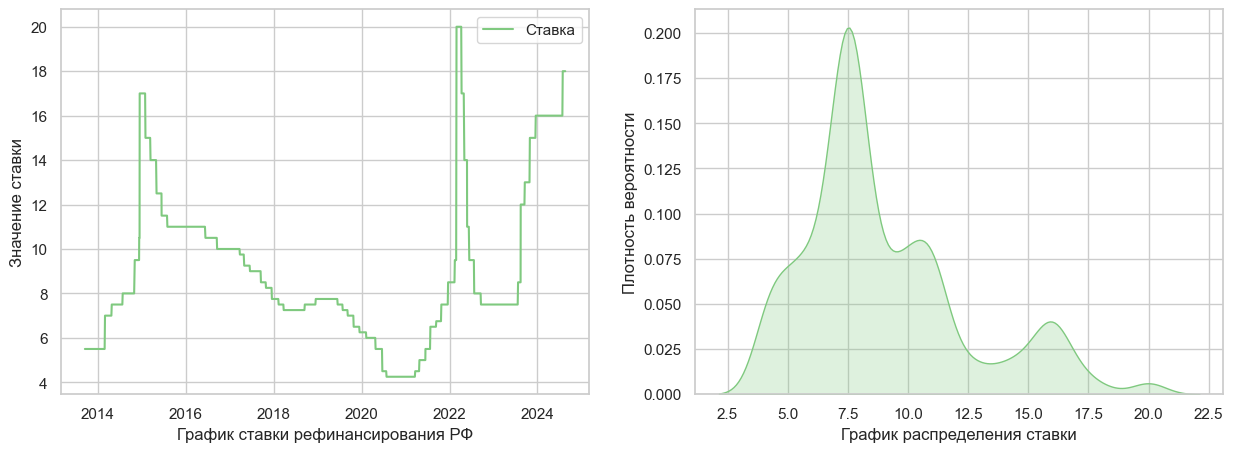

In [80]:
# Смотрим график курса ключевой ствки ЦБ РФ и график распределения
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=ax[0])
ax[0].set_xlabel('График ставки рефинансирования РФ')
ax[0].set_ylabel('Значение ставки')
ax[0].legend(loc='best')
ax[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=ax[1], fill=True)
ax[1].grid(True)
ax[1].set_xlabel('График распределения ставки')
ax[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [81]:
# Проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9010310169824747, pvalue=7.570196959252413e-39)
Распределение не нормальное


In [82]:
# Определение категориальных типов данных для дней недели и месяцев
cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

def create_features(data, col_datetime):
    """
    Создание новых признаков из столбца datetime в pandas DataFrame.

    Параметры:
    data (pd.DataFrame): Входной DataFrame
    col_datetime (str): Имя столбца datetime

    Возвращает:
    pd.DataFrame: DataFrame с добавленными новыми признаками
    """
    # Создание копии входного DataFrame, чтобы избежать его изменения
    data = data.copy()

    # Преобразование столбца datetime в формат datetime
    data[col_datetime] = pd.to_datetime(data[col_datetime])

    # Создание новых признаков
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)  # День недели
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)  # Месяц года
    data['year'] = data[col_datetime].dt.year  # Год
    data['quarter'] = data[col_datetime].dt.quarter  # Квартал года
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data[col_datetime].dt.day - 320) % 1300  # Пользовательский признак смещения даты
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})  # Сезон года

    return data

In [83]:
# Создание признаков
df_features = create_features(data=df, col_datetime='date')

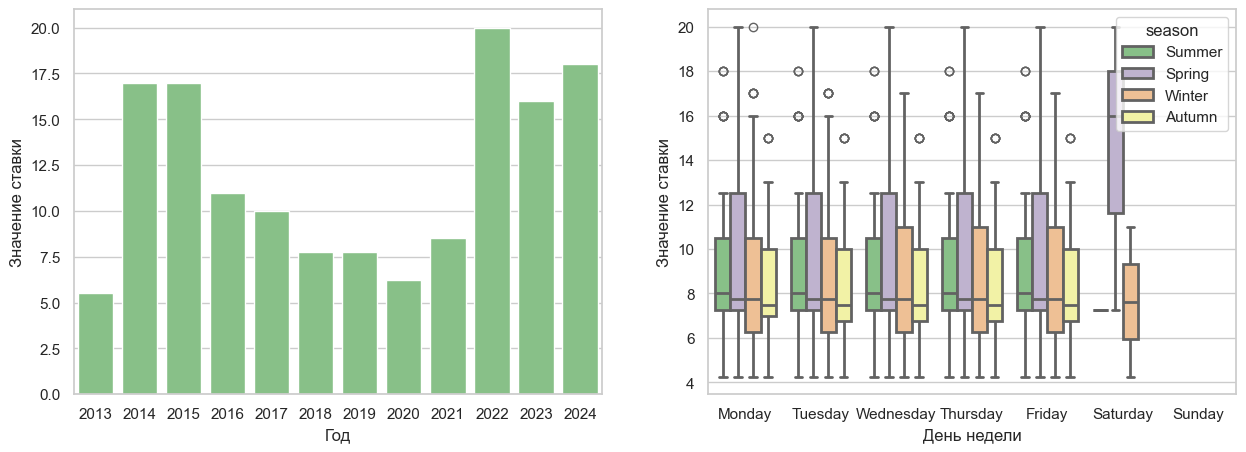

In [84]:
# Смотрим графики для анализа
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=ax[0])
ax[0].set_xlabel('Год')
ax[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=ax[1], linewidth=2)
ax[1].set_xlabel('День недели')
ax[1].set_ylabel('Значение ставки')

plt.show()



## Дропаем редкие субботние ставки

In [ ]:
# Дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

Смотрим график после дропа суббот

In [ ]:
# Создаем df с признаками после дропа суббот
df_features = create_features(data=df, col_datetime='date')

In [ ]:
# Смотрим графики для анализа после дропа суббот
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=ax[0])
ax[0].set_xlabel('Год')
ax[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=ax[1], linewidth=2)
ax[1].set_xlabel('День недели')
ax[1].set_ylabel('Значение ставки')

plt.show()

## Поиск и удаление статистических выбросов

Далее будем вычислять и убирать статистические выбросы

## Определение выбросов при помощи IQR

In [ ]:
# Определение последней даты, для заполнения графика интерполяцией
last_date = df['date'].max()

# Настройка фильтрации данных до последней даты
mask = df['date'] < last_date

# Вычисление межквартильного размаха (IQR)
q1 = df.loc[mask, 'key_rate'].quantile(0.25)
q3 = df.loc[mask, 'key_rate'].quantile(0.75)
iqr = q3 - q1

# Определение границ для выбросов
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Замена выбросов на NaN
df_filtered = df.copy()
df_filtered.loc[(df_filtered['key_rate'] < lower_bound) & mask, 'key_rate'] = np.nan
df_filtered.loc[(df_filtered['key_rate'] > upper_bound) & mask, 'key_rate'] = np.nan


In [ ]:
# Считаем количество статистических выбросов
print(df_filtered['key_rate'].isna().sum())

In [ ]:
# Визуализация после вычисления выбросов
fig, ax = plt.subplots(figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Оригинальные данные', ax=ax)
sns.lineplot(x='date', y='key_rate', data=df_filtered, label='Отфильтрованные данные', ax=ax)

ax.set_xlabel('Год')
ax.set_ylabel('Значение ставки')
ax.set_title('Визуализация после вычисления выбросов')
ax.legend(loc='best')
ax.grid(True)

In [ ]:
# Интерполируем пропущенные значения
df_filtered['key_rate'] = df_filtered['key_rate'].interpolate(method='nearest', order=3)

# Считаем количество статистических выбросов после интерполяции
print(df_filtered['key_rate'].isna().sum())

In [ ]:
# Создаем df с признаками после замены статистических выбросов
df_features = create_features(data=df_filtered, col_datetime='date')

In [ ]:
# Смотрим графики для анализа
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=ax[0])
ax[0].set_xlabel('Год')
ax[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=ax[1], linewidth=2)
ax[1].set_xlabel('День недели')
ax[1].set_ylabel('Значение ставки')

plt.show()

In [ ]:
# Смотрим график после замены выбросов интерполяцией пропущенных значений
fig, ax = plt.subplots(figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Оригинальные данные', ax=ax)
sns.lineplot(x='date', y='key_rate', data=df_filtered, label='Отфильтрованные данные', ax=ax)

ax.set_xlabel('Год')
ax.set_ylabel('Значение ставки')
ax.set_title('Визуализация после замены выбросов пропущенных значений интерполяцией')
ax.legend(loc='best')
ax.grid(True)

In [ ]:
# сохранение отфилтрованных данных в df
df = df_filtered

In [ ]:
# Перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.15)


In [ ]:
# Сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [ ]:
# Разделение данных на train, test
df_train = df[:-pred_days]
df_test = df[-pred_days:]


In [ ]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [ ]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)
